In [17]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from utilitary import *
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [1]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

### Exploratory data analysis

By looking at our data we see there are some invalid values. To quantify them we look at the different features and compute the percentage of invalid values for each one of them.

In [2]:
def print_percentages(array):
    for j in range(array.shape[1]):
        count_col = 0
        for i in range(array.shape[0]):
            if array[i,j] == -999:
                count_col += 1
        count_col = (count_col/array.shape[0])*100
        if (count_col > 0) : 
            print(f'For the feature {j+1} : {count_col} % of missing values')
        
print_percentages(tX)

For the feature 1 : 15.245600000000001 % of missing values
For the feature 5 : 70.9828 % of missing values
For the feature 6 : 70.9828 % of missing values
For the feature 7 : 70.9828 % of missing values
For the feature 13 : 70.9828 % of missing values
For the feature 24 : 39.9652 % of missing values
For the feature 25 : 39.9652 % of missing values
For the feature 26 : 39.9652 % of missing values
For the feature 27 : 70.9828 % of missing values
For the feature 28 : 70.9828 % of missing values
For the feature 29 : 70.9828 % of missing values


It also seems that some elements in feature 23 (PRI_jet_num) and 30 (PRI_jet_all_pt) have value 0 or 1 for elements with missing value

In [3]:
zero_percentage_23 = (np.count_nonzero((tX[:, 22] == 1) | (tX[:, 22] == 0)) / tX.shape[0]) * 100
zero_percentage_30 = (np.count_nonzero(tX[:, 29] == 0) / tX.shape[0]) * 100

print(f'For the feature 23 : {zero_percentage_23} % of zero values')
print(f'For the feature 30 : {zero_percentage_30} % of zero values')

For the feature 23 : 70.9828 % of zero values
For the feature 30 : 39.9652 % of zero values


We notice that the elements seem to fit in four different categories. 15 % of our elements are missing values in the first feature, about 40% are missing values in features 24, 25, 26 and 30, and about 70% are missing values in features 5, 6, 7, 13, 23, 27, 28 and 29.

### Data pre-processing

Because each of the different categories of elements will most likely affect the output in a different way, we choose to split our data in 4 sub-samples based on those categories to train a model for each of them separately.

In [4]:
def build_mask(tx) : 
    mask1 = tx[:, 0] == -999
    mask2 = (tx[:, 23] == -999) & (tx[:, 0] != -999)
    mask3 = (tx[:, 4] == -999) & (tx[:, 23] != -999) & (tx[:, 0] != -999)
    mask4 = (tx[:, 4] != -999) & (tx[:, 23] != -999) & (tx[:, 0] != -999)
    
    return mask1, mask2, mask3, mask4

def build_subsample(tx, mask) :
    feature_mask = []
    for j in range(tx.shape[1]):
        if (j == 22) :
            feature_mask.append(not ((0 in tx[mask][:,j]) | (1 in tx[mask][:,j])))
        elif (j == 29) :
            feature_mask.append(not ((0 in tx[mask][:,j])))
        else :
            feature_mask.append(not (-999 in tx[mask][:,j]))
        
    subsample = tx[mask][:, feature_mask]
    
    return subsample
        
def split_categories(tx) :
    m1, m2, m3, m4  = build_mask(tx)
    
    s1 = build_subsample(tx, m1)
    s2 = build_subsample(tx, m2)
    s3 = build_subsample(tx, m3)
    s4 = build_subsample(tx, m4)
    
    return s1, s2, s3, s4, m1, m2, m3, m4

In [5]:
x1, x2, x3, x4, mask1, mask2, mask3, mask4 = split_categories(tX)
print("Subsample x1 has ", x1.shape[0], " elements, ", x1.shape[1], " features and no invalid values: ", (not(-999 in x1)))
print("Subsample x2 has ", x2.shape[0], " elements, ", x2.shape[1], " features and no invalid values: ", (not(-999 in x2)))
print("Subsample x3 has ", x3.shape[0], " elements, ", x3.shape[1], " features and no invalid values: ", (not(-999 in x3)))
print("Subsample x4 has ", x4.shape[0], " elements, ", x4.shape[1], " features and no invalid values: ", (not(-999 in x4)))

Subsample x1 has  38114  elements,  17  features and no invalid values:  True
Subsample x2 has  73790  elements,  18  features and no invalid values:  True
Subsample x3 has  69982  elements,  22  features and no invalid values:  True
Subsample x4 has  68114  elements,  30  features and no invalid values:  True


In [6]:
x1_test, x2_test, x3_test, x4_test, mask1_test, mask2_test, mask3_test, mask4_test = split_categories(tX_test)

To process our data we choose to normalize it, i.e transforming all values to be between 0 and 1. This allows for a more homogeneous dataset and avoids large values that could result in overflow or other issues

In [36]:
#normalize the matrix
def normalize(tx, tx_test) :
    tx_normalized = tx.copy()
    tx_test_normalized = tx_test.copy()
    for index, feature in enumerate(tx_normalized.T) :
        diff = np.amax(feature) - np.amin(feature)
        normalized_feature = (feature - np.amin(feature))/diff
        normalized_test_feature = (tx_test_normalized.T[index] - np.amin(feature))/diff
        #standardized_test_feature = (tx_test_normalized.T[index]-feature.mean())/feature.std()
        #standardized_feature = (feature-feature.mean())/feature.std()
        if ((diff != 0) & (diff != 1)) : #avoids normalizing categorical features resulting in singular matrices
            feature[:] = normalized_feature
            tx_test_normalized.T[index, :] = normalized_test_feature
    return tx_normalized, tx_test_normalized

In [37]:
x1_normalized, x1_test_normalized = normalize(x1, x1_test)
x2_normalized, x2_test_normalized = normalize(x2, x2_test)
x3_normalized, x3_test_normalized = normalize(x3, x3_test)
x4_normalized, x4_test_normalized = normalize(x4, x4_test)

In [38]:
masks_test = np.array([mask1_test, mask2_test, mask3_test, mask4_test])

masks = np.array([mask1, mask2, mask3, mask4])
X = np.array([x1, x2, x3, x4])
X_normalized = np.array([x1_normalized, x2_normalized, x3_normalized, x4_normalized])

In [11]:
# standardize the matrix 
def standardize(tX, normalized = False) :
    tX_standardized = tX.copy()
    for feature in tX_standardized.T : 
        mask = (feature != -999)
        i_mask = (feature == -999)
        feature[i_mask] = feature[mask].mean() # replace undetermined value by mean of other values in the feature column
        feature[:] = (feature-feature.mean())/feature.std() # standardize
        if normalized :
            feature[:] = (feature - np.amin(feature))/(np.amax(feature) - np.amin(feature)) # normalize
    tX_standardized.T[22] = tX.T[22] # Avoid standardization on categorical feature
    tX_standardized = np.delete(tX_standardized, 7343, 0) #remove outlier
    # tX_standardized = np.c_[tX_standardized, np.ones((tX_standardized.shape[0], 1))] # Add row of ones for better regression
    return tX_standardized

### Features cleaning
We don't need that, keeping just in case

Even after standardizing our data we might not want certain columns or rows. For this reason we create some masks to apply to our dataset that could improve accuracy

In [12]:
mask_dict = {}
no_mask = np.full(tX_standardized_af.shape[1], True)
# no_mask[30] = False
mask_dict["no_mask"] = no_mask

NameError: name 'tX_standardized_af' is not defined

In [12]:
# Create mask removing columns with unvalid data
remove_na_mask = []
for j in range(tX.shape[1]):
    remove_na_mask.append(not (-999 in tX[:,j]))
# remove_na_mask.append(False) # for 1 column

mask_dict["remove_na_mask"] = remove_na_mask

NameError: name 'mask_dict' is not defined

In [ ]:
# Create mask removing columns with unvalid data except the first one because it has only 15% on error
remove_error_mask = []
for j in range(tX.shape[1]):
    remove_error_mask.append(not (-999 in tX[:,j]))
remove_error_mask[0] = True
# remove_error_mask.append(False) # for 1 column

mask_dict["remove_error_mask"] = remove_error_mask

We notice some features do not have invalid data but do have a 0 value for almost every row containing some invalid data. We create a mask removing all of them in case it offers better accuracy on our methods.

In [ ]:
# Create mask removing all columns with unvalid or 0 data
remove_all_mask = []
for j in range(tX.shape[1]):
    remove_all_mask.append(not (-999 in tX[:,j]))
remove_all_mask[29] = False
remove_all_mask[22] = False
# remove_all_mask.append(False)

mask_dict["remove_all_mask"] = remove_all_mask

We now want to create a mask selecting only the features bringing the most information about y. To do so we calculate the correlation of each of the features with y and select only the ones with best correlation.

In [16]:
# Sort features based on their correlation with y
correlations = np.zeros(tX_standardized_af.shape[1] - 1)
for i in range(len(correlations)) :
    correlations[i] = np.corrcoef(y, tX_standardized_af.T[i])[0][1]
sorted_features_correlations = np.array(sorted(list(enumerate(correlations)), key=lambda x: -np.abs(x[1])))
sorted_features_indexes = np.array(sorted_features[:, 0], dtype = int)

NameError: name 'tX_standardized_af' is not defined

In [17]:
# Create a mask based on the n features with best correlation with y
n = 15
best_corr_mask = sorted(sorted_features_indexes[:n])


mask_dict["best_corr_mask"] = best_corr_mask 
best_corr_mask

NameError: name 'sorted_features_indexes' is not defined

In [18]:
# for i, feature in enumerate(tX_standardized.T) :
#    print("Feature " , i+1)
#    plt.plot(feature[:1000], y[:1000], 'kp', alpha = 0.006)
#    plt.show()

### Useful functions

In [10]:
''' Calculate accuracy of model'''
def accuracy_function(weights, x, y) :
    y_pred = predict_labels(weights, x)
    return np.count_nonzero(y == y_pred) / (y.shape[0])

In [11]:
''' Compute the overall accuracy when the dataset has been divided into categories '''
def total_accuracy(weights, x, y, masks) :
    total_count = 0
    for i in range(weights.shape[0]) :
        y_pred = predict_labels(weights[i], x[i])
        total_count += np.count_nonzero(y[masks[i]] == y_pred)
    return total_count / (y.shape[0])

In [12]:
''' Create a dictionary which enable to compute the different methods in a modularized way '''
methods = {
    "least_squares_GD" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: least_squares_GD(y, tx, initial_w, max_iters, gamma)),
    "least_squares_SGD" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: least_squares_SGD(y, tx, initial_w, max_iters, gamma)),
    "least_squares": (lambda y, tx, lambda_, initial_w, max_iters, gamma: least_squares(y, tx)),
    "ridge_regression" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: ridge_regression(y, tx, lambda_)),
    "logistic_regression" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: logistic_regression(y, tx, initial_w, max_iters, gamma)),
    "reg_logistic_regression" : (lambda y, tx, lambda_, initial_w, max_iters, gamma: reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma))   
}

In [39]:
""" Build k indices for k-fold """
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)


''' 
Doing k-fold cross validation for the parameter(s) entered.
Return the average accuracy obtained for the training and testing set
'''
def cross_validation(k_fold, method, y, tx_poly, lambda_ = 0, max_iters = 1, gamma = 0, cross = False):
    
    # define lists to store the accuracy of training data and test data for the given parameter
    acc_tr_param = []
    acc_te_param = []
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed = 2)

    initial_w = np.zeros(tx_poly.shape[1])
    
    for k in range(k_fold):
        
        te_indice = k_indices[k]
        tr_indice = np.delete(k_indices, k, 0)
        tr_indice = np.ndarray.flatten(tr_indice)

        tr_x = tx_poly[tr_indice]
        tr_y = y[tr_indice]
        te_x = tx_poly[te_indice]
        te_y = y[te_indice]
        
        # method call
        w, loss = method(tr_y, tr_x, lambda_, initial_w, max_iters, gamma)

        acc_tr_param.append(accuracy_function(w, tr_x, tr_y))
        acc_te_param.append(accuracy_function(w, te_x, te_y))
    
    return np.mean(acc_tr_param), np.mean(acc_te_param)

In [42]:
'''
Determine the optimal parameter(s) for the given method. Putting default values for the different parameters enable 
to call determine_parameter for every method.
method is the function that compute the weights and the loss.
Return the optimal parameters: degree, lambda, gamma (if only a subset of the parameters is used, consider only 
the wanted parameters and others are just default values)
'''
def determine_parameter(method, tx, y, cross, degrees = [1], lambdas = [0], gammas = [0], k_fold = 4, max_iters = 1, name = 'x'):
    
    # define a matrix to store the accuracy of training data and test data
    acc_tr_matrix = np.zeros(shape = (len(degrees), len(lambdas), len(gammas)))
    acc_te_matrix = np.zeros(shape = (len(degrees), len(lambdas), len(gammas)))
    initial_w = np.zeros(tx.shape[1])
    for h, degree in enumerate(degrees) :
        # feature expansion
        if cross:
            tx_poly = build_all(tx, degree)
        else:
            tx_poly = build_multi_poly(tx, degree)
        for i, lambda_ in enumerate(lambdas) :
            for j, gamma in enumerate(gammas) :
                acc_tr_matrix[h, i, j], acc_te_matrix[h, i, j] = cross_validation(k_fold, method, y, tx_poly, lambda_ = lambda_, max_iters = max_iters, gamma = gamma, cross = cross)
    
    # find the indices of the maximum accuracy in 'acc_te_matrix'
    max_acc_index = np.unravel_index(acc_te_matrix.argmax(), acc_te_matrix.shape)
     # maximum accuracy in 'acc_te_matrix'
    max_acc = acc_te_matrix[max_acc_index]
    
    # optimal parameters
    degree = degrees[max_acc_index[0]]
    lambda_ = lambdas[max_acc_index[1]]
    gamma = gammas[max_acc_index[2]]
    
    # Plot only the wanted parameter(s) in function of the accuracy.
    # When plotting a specific parameter others parameters are optimal.
    if len(degrees) > 1:
        if (lambda_ != 0) : print("Lambda = ", lambda_)
        if (gamma != 0) : print("Gamma = ", gamma)
        title = 'Optimal degree for ' + name
        degree_plot = plot_train_test(acc_tr_matrix[:, max_acc_index[1], max_acc_index[2]], acc_te_matrix[:, max_acc_index[1], max_acc_index[2]], degrees, title, 'degree')
        print("Optimal degree :", degree, '\n')
    if len(lambdas) > 1:
        if (degree != 1) : print("Degree = ", degree)
        if (gamma != 0) : print("Gamma = ", gamma)
        title = 'Optimal lambda for ' + name
        lambdas_plot = plot_train_test(acc_tr_matrix[max_acc_index[0], :, max_acc_index[2]], acc_te_matrix[max_acc_index[0], :, max_acc_index[2]], lambdas, title, 'lambda', log = True)
        print("Optimal lambda :", lambda_, '\n')
    if len(gammas) > 1:
        if (degree != 1) : print("Degree = ", degree)
        if (lambda_ != 0) : print("Lambda = ", lambda_)
        title = 'Optimal gamma for ' + name
        gammas_plot = plot_train_test(acc_tr_matrix[max_acc_index[0], max_acc_index[1], :], acc_te_matrix[max_acc_index[0], max_acc_index[1], :], gammas, title, 'gamma', log = True)
        print("Optimal gamma :", gamma, '\n')
    print("Max accuracy :", max_acc)
    
    return degree, lambda_, gamma

In [54]:
'''
Generate the optimal parameters that enable to train the model into the whole dataset and to have the optimal 
weights.
X: categorized dataset(X[0] represent the first category)

Return all useful information of the model: optimal weights for each category, dataset 
matrix with feature expansion for each category, optimal parameters and the accuracy.
'''
def analyze_method(method, X, y, masks, degrees = [1], lambdas = [0], gammas = [0], max_iters = 1, k_fold = 4, name = "x", cross = False) :
    optimal_degree = np.zeros(X.shape[0], dtype = int)
    optimal_lambda = np.zeros(X.shape[0])
    optimal_gamma = np.zeros(X.shape[0])
    # expansion features of the dataset with the optimal degree.
    X_poly = []
    # weights 
    W = []
    # loss
    L = []
    
    # for each catagory fill in W and L.
    for i in range(X.shape[0]) :
        temp_name = name + str(i+1)
        optimal_degree[i], optimal_lambda[i], optimal_gamma[i] = determine_parameter(method, X[i], y[masks[i]], cross, degrees = degrees, lambdas = lambdas, gammas = gammas, max_iters = max_iters, k_fold = k_fold, name = temp_name)
        X_poly.append(build_multi_poly(X[i], optimal_degree[i]))
        initial_w = np.zeros(X_poly[i].shape[1])
        w_temp, l_temp = method(y[masks[i]], X_poly[i], optimal_lambda[i], initial_w, max_iters, optimal_gamma[i])
        W.append(w_temp)
        L.append(l_temp)
    X_poly = np.array([X_poly[0], X_poly[1], X_poly[2], X_poly[3]])
    W = np.array([W[0], W[1], W[2], W[3]])
    L = np.array([L[0], L[1], L[2], L[3]])
    
    
    accuracy = total_accuracy(W, X_poly, y, masks)
    print("Accuracy with optimal parameters is :", accuracy * 100, '%')
    
    return W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy

### Ridge regression with polynomial expansion on features (cross)

Lambda =  1e-15


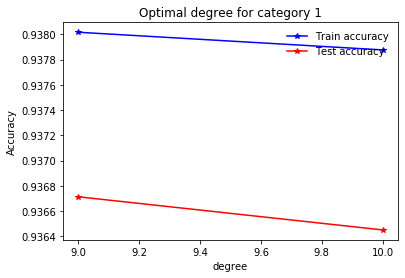

Optimal degree : 9 

Degree =  9


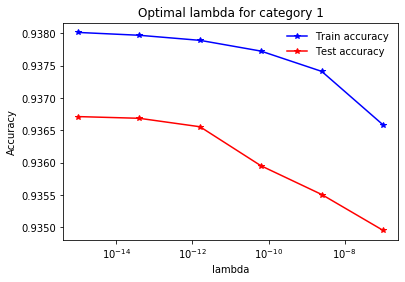

Optimal lambda : 1e-15 

Max accuracy : 0.9367128463476071
Lambda =  1.584893192461111e-12


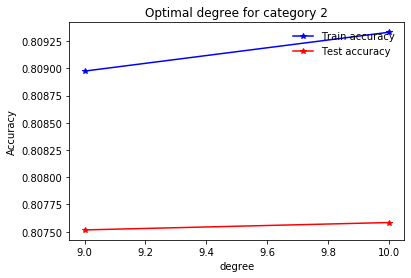

Optimal degree : 10 

Degree =  10


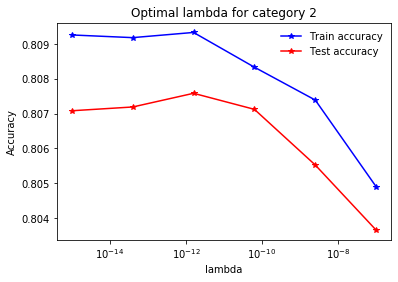

Optimal lambda : 1.584893192461111e-12 

Max accuracy : 0.8075838889792377


In [ ]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["ridge_regression"], X_normalized, y, masks, cross = True, degrees = np.arange(9, 11),lambdas = np.logspace(-15, -7, 6), name = "category ")

### Least square with polynomial expansion on features

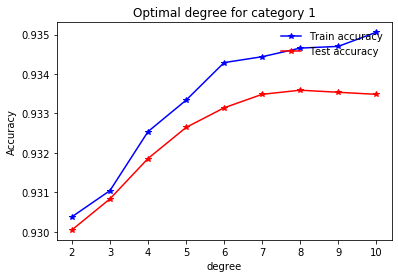

Optimal degree : 8 

Max accuracy : 0.933590470193115


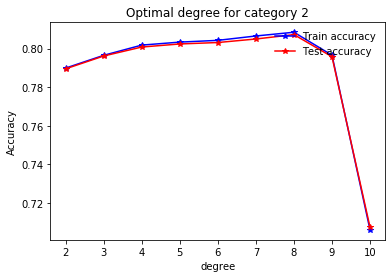

Optimal degree : 8 

Max accuracy : 0.8072044234834933


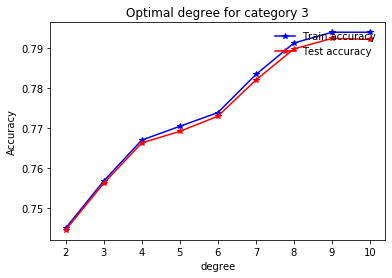

Optimal degree : 9 

Max accuracy : 0.7923692483566733


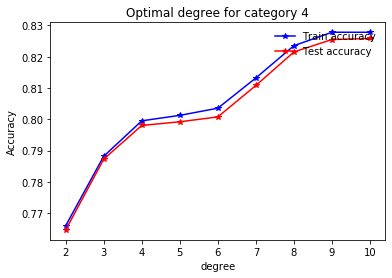

Optimal degree : 10 

Max accuracy : 0.8258016208597604
Accuracy with optimal parameters is : 82.8532 %


In [44]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["least_squares"], X_normalized, y, masks, degrees = np.arange(2, 11), name = "category ")

### Least square with polynomial expansion on features (cross)

In [ ]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["least_squares"], X_normalized, y, masks, degrees = np.arange(2, 11), name = "category ", cross = True)

### Least square gradient with polynomial expansion on features 

Gamma =  1e-10


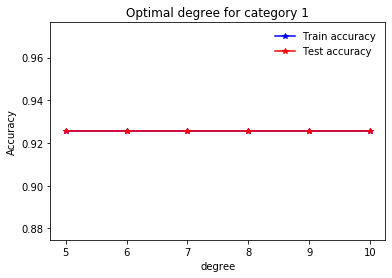

Optimal degree : 5 

Degree =  5


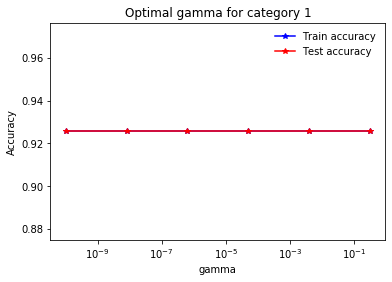

Optimal gamma : 1e-10 

Max accuracy : 0.9256139798488665
Gamma =  0.31622776601683794


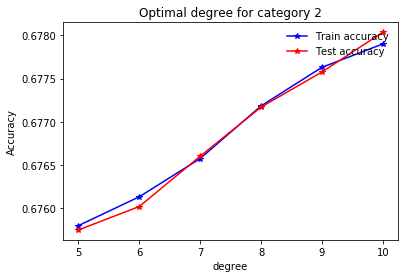

Optimal degree : 10 

Degree =  10


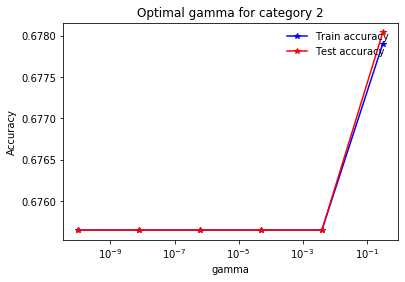

Optimal gamma : 0.31622776601683794 

Max accuracy : 0.6780370791998699
Gamma =  0.31622776601683794


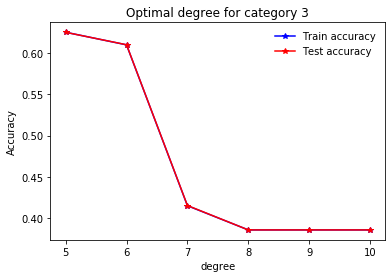

Optimal degree : 5 

Degree =  5


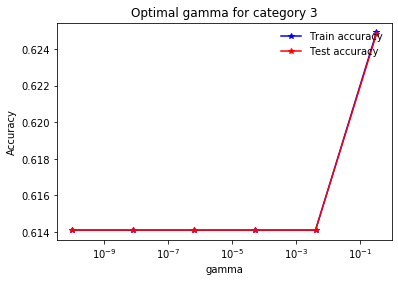

Optimal gamma : 0.31622776601683794 

Max accuracy : 0.624821377536439
Gamma =  1e-10


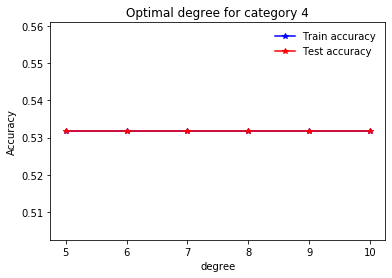

Optimal degree : 5 

Degree =  5


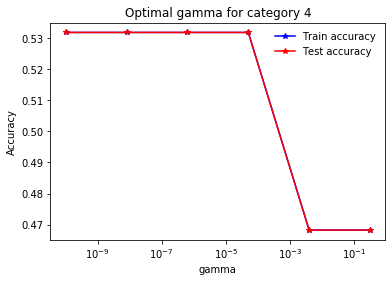

Optimal gamma : 1e-10 

Max accuracy : 0.5317565186751233
Accuracy with optimal parameters is : 66.1028 %


In [55]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["least_squares_GD"], X_normalized, y, masks, degrees = np.arange(5, 11), gammas = np.logspace(-10, -0.5, 6), max_iters = 10, name = "category ")

### Least square gradient with polynomial expansion on features (cross)

In [ ]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["least_squares_GD"], X_normalized, y, masks, cross= True, degrees = np.arange(5, 11), gammas = np.logspace(-10, -0.5, 6), max_iters = 10, name = "category ")

### Ridge regression with polynomial expansion on features

Lambda =  1e-14


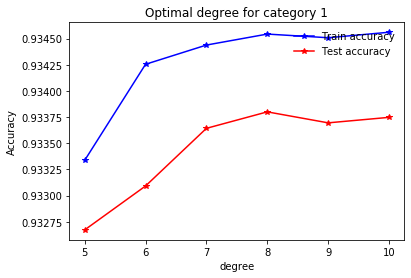

Optimal degree : 8 

Degree =  8


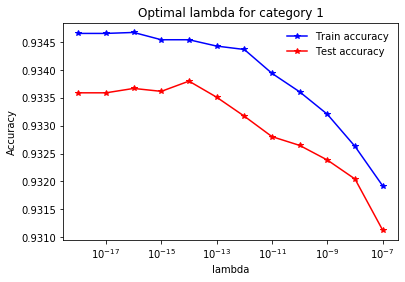

Optimal lambda : 1e-14 

Max accuracy : 0.9338003778337531
Lambda =  1e-18


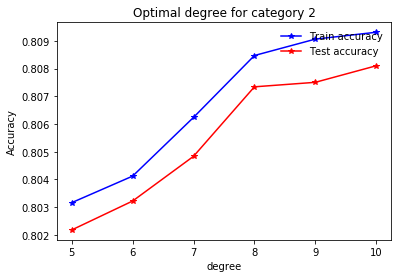

Optimal degree : 10 

Degree =  10


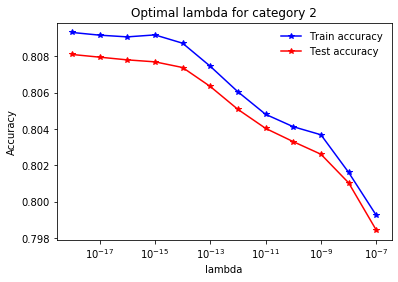

Optimal lambda : 1e-18 

Max accuracy : 0.8080988778663197
Lambda =  1e-17


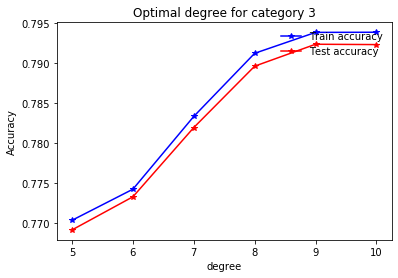

Optimal degree : 9 

Degree =  9


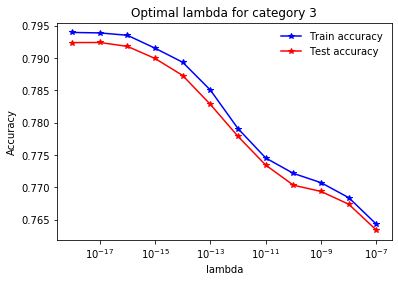

Optimal lambda : 1e-17 

Max accuracy : 0.7923978279508431
Lambda =  1e-18


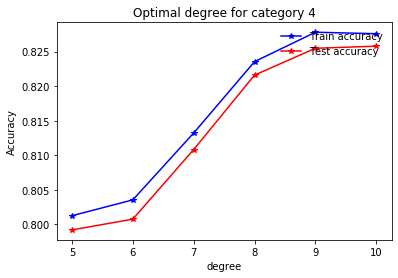

Optimal degree : 10 

Degree =  10


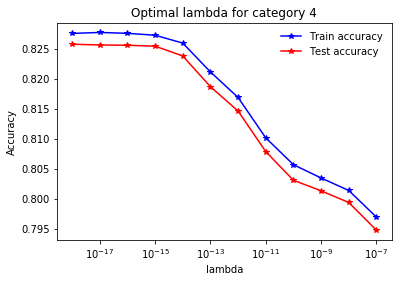

Optimal lambda : 1e-18 

Max accuracy : 0.825772257458304
Accuracy with optimal parameters is : 82.8896 %


In [47]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["ridge_regression"], X_normalized, y, masks, degrees = np.arange(5, 11),lambdas = np.logspace(-18, -7, 12), name = "category ")

### Logistic regression with polynomial expansion on features

Gamma =  1e-10


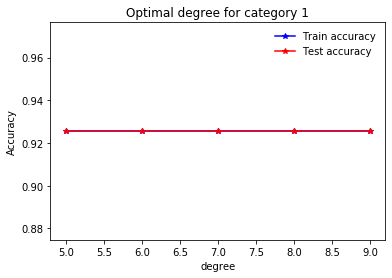

Optimal degree : 5 

Degree =  5


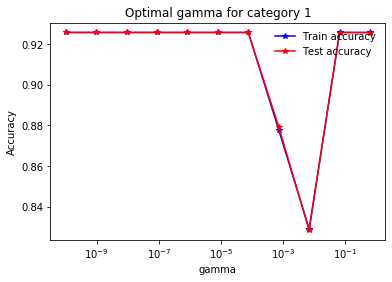

Optimal gamma : 1e-10 

Max accuracy : 0.9256139798488665
Gamma =  7.585775750291851e-05


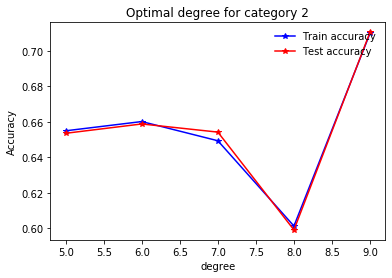

Optimal degree : 9 

Degree =  9


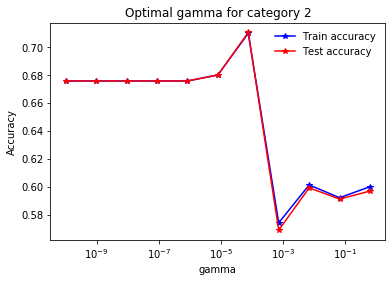

Optimal gamma : 7.585775750291851e-05 

Max accuracy : 0.7104000650512278
Gamma =  7.943282347242822e-06


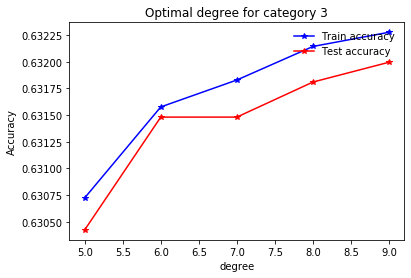

Optimal degree : 9 

Degree =  9


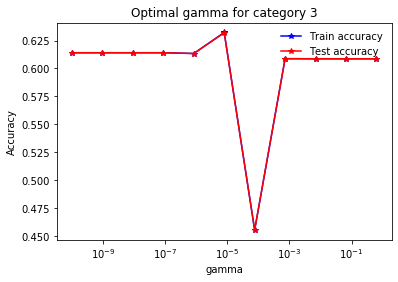

Optimal gamma : 7.943282347242822e-06 

Max accuracy : 0.6319948556730495
Gamma =  0.0007244359600749906


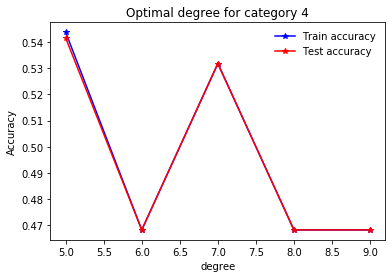

Optimal degree : 5 

Degree =  5


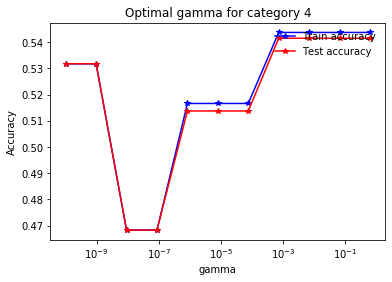

Optimal gamma : 0.0007244359600749906 

Max accuracy : 0.5415051679586563
Accuracy with optimal parameters is : 66.3668 %


In [49]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["logistic_regression"], X_normalized, y, masks, degrees = np.arange(5, 10),gammas = np.logspace(-10, -0.2, 11), max_iters = 50, name = "category ")

### Logistic regression with polynomial expansion on features (cross)

In [ ]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["logistic_regression"], X_normalized, y, masks, degrees = np.arange(5, 9), gammas = np.logspace(-10, -0.2, 4), cross = True, max_iters = 50, name = "category ")

### Linear SGD with polynomial expansion on features (cross)


In [56]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["least_squares_SGD"], X_normalized, y, masks, cross= True, degrees = np.arange(5, 11), gammas = np.logspace(-10, -0.5, 6), max_iters = 10, name = "category ")

KeyboardInterrupt: 

### Linear SGD with polynomial expansion on features


Gamma =  1e-10


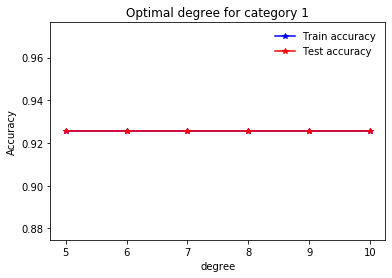

Optimal degree : 5 

Degree =  5


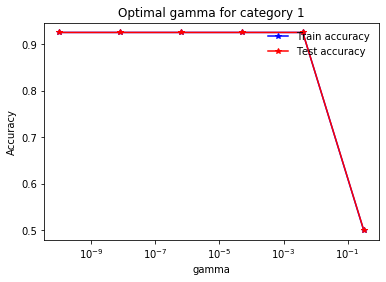

Optimal gamma : 1e-10 

Max accuracy : 0.9256139798488665
Gamma =  0.003981071705534969


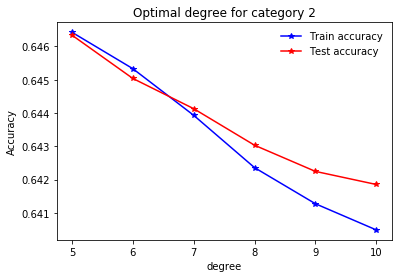

Optimal degree : 5 

Degree =  5


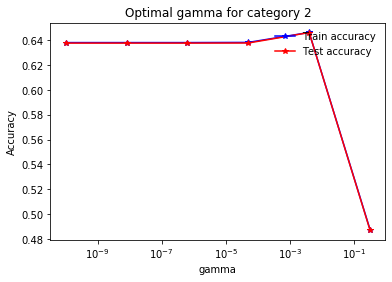

Optimal gamma : 0.003981071705534969 

Max accuracy : 0.646338157966065
Gamma =  0.003981071705534969


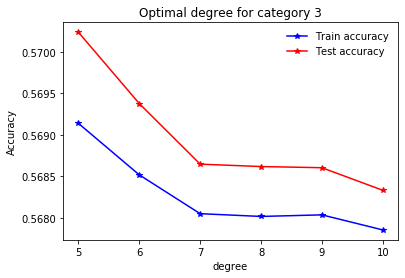

Optimal degree : 5 

Degree =  5


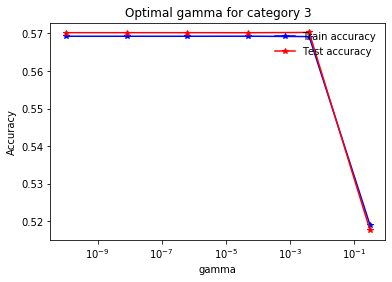

Optimal gamma : 0.003981071705534969 

Max accuracy : 0.570234352672192
Gamma =  0.003981071705534969


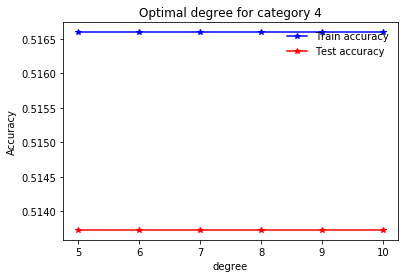

Optimal degree : 5 

Degree =  5


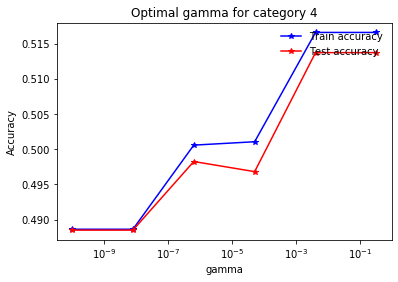

Optimal gamma : 0.003981071705534969 

Max accuracy : 0.5137273901808785
Accuracy with optimal parameters is : 65.7332 %


In [57]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["least_squares_SGD"], X_normalized, y, masks, degrees = np.arange(5, 11), gammas = np.logspace(-10, -0.5, 6), max_iters = 10, name = "category ")

### Regularized logistic regression with polynomial expansion on features


Degree =  8
Gamma =  0.6309573444801932


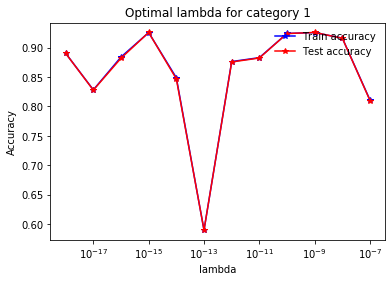

Optimal lambda : 1e-09 

Degree =  8
Lambda =  1e-09


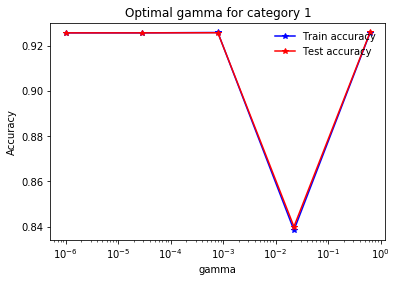

Optimal gamma : 0.6309573444801932 

Max accuracy : 0.9257976490344249
Degree =  8
Gamma =  2.818382931264455e-05


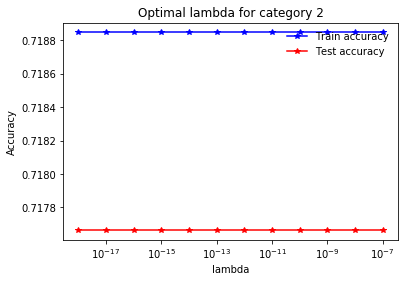

Optimal lambda : 1e-18 

Degree =  8
Lambda =  1e-18


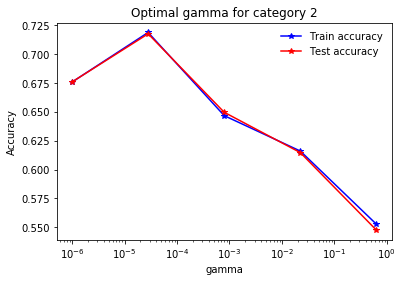

Optimal gamma : 2.818382931264455e-05 

Max accuracy : 0.7176641188269096
Degree =  8
Gamma =  1e-06


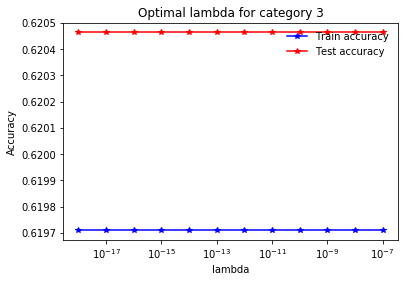

Optimal lambda : 1e-18 

Degree =  8
Lambda =  1e-18


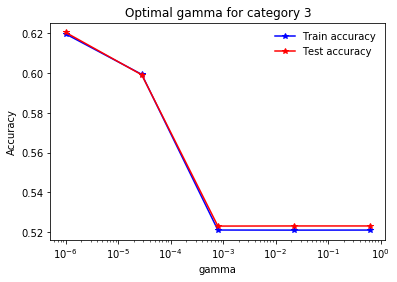

Optimal gamma : 1e-06 

Max accuracy : 0.6204629894255501
Degree =  8
Gamma =  2.818382931264455e-05


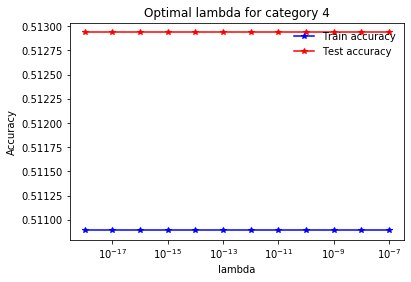

Optimal lambda : 1e-18 

Degree =  8
Lambda =  1e-18


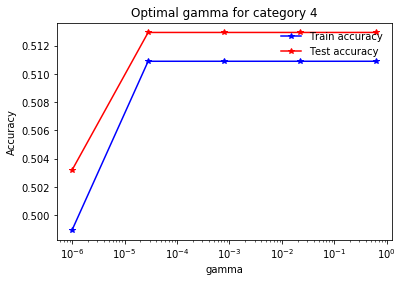

Optimal gamma : 2.818382931264455e-05 

Max accuracy : 0.5129345783415551
Accuracy with optimal parameters is : 64.6208 %


In [59]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["reg_logistic_regression"], X_normalized, y, masks,  degrees = [8],  lambdas = np.logspace(-18, -7, 12), gammas = np.logspace(-6, -0.2, 5), max_iters = 50, name = "category ")

### Regularized logistic regression with polynomial expansion on features (cross)


In [ ]:
W, X_poly, optimal_degree, optimal_lambda, optimal_gamma, accuracy = analyze_method(methods["reg_logistic_regression"], X_normalized, y, masks, cross = True  degrees = [9],gammas = np.logspace(-10, -0.2, 4), lambdas = np.logspace(-18, -7, 12) max_iters = 50, name = "category ")

## Generate predictions and save ouput in csv format for submission:

In [59]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [94]:
x1_test_poly = build_multi_poly(x1_test_normalized, optimal_degree[0])
x2_test_poly = build_multi_poly(x2_test_normalized, optimal_degree[1])
x3_test_poly = build_multi_poly(x3_test_normalized, optimal_degree[2])
x4_test_poly = build_multi_poly(x4_test_normalized, optimal_degree[3])

X_test = np.array([x1_test_poly, x2_test_poly, x3_test_poly, x4_test_poly])

In [95]:
OUTPUT_PATH = '../data/submission_file.csv' # TODO: fill in desired name of output file for submission
y_pred = np.zeros(tX_test.shape[0])

y_pred[masks_test[0]] = predict_labels(W[0], X_test[0])
y_pred[masks_test[1]] = predict_labels(W[1], X_test[1])
y_pred[masks_test[2]] = predict_labels(W[2], X_test[2])
y_pred[masks_test[3]] = predict_labels(W[3], X_test[3])
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)